In [1]:
import pandas as pd
import acbm

# Read in the data 

In [55]:
# NTS data 
legs_nts = pd.read_parquet(
    acbm.root_path / "data/external/nts/filtered/nts_trips.parquet"
)

legs_nts = legs_nts[legs_nts["TravDay"] == 3]

# Model outputs 
legs_acbm = pd.read_csv(
    acbm.root_path / "data/processed/activities_pam/legs.csv"
)
legs_acbm_geo = pd.read_parquet(
    acbm.root_path / "data/processed/activities_pam/legs_with_locations.parquet"
)



In [41]:
legs_acbm


,Unnamed: 0,pid,hid,freq,ozone,dzone,purp,origin activity,destination activity,mode,seq,tst,tet,duration
0,0,199,89,NaN,E00059031,E00058720,other,home,other,walk,1.0,1900-01-01 10:00:00,1900-01-01 10:45:00,0:45:00
1,1,199,89,NaN,E00058720,E00059031,home,other,home,walk,2.0,1900-01-01 10:45:00,1900-01-01 11:30:00,0:45:00
2,2,199,89,NaN,E00059031,E00057312,shop,home,shop,car,3.0,1900-01-01 12:00:00,1900-01-01 12:10:00,0:10:00
3,3,199,89,NaN,E00057312,E00059031,home,shop,home,car,4.0,1900-01-01 12:45:00,1900-01-01 12:55:00,0:10:00
4,4,199,89,NaN,E00059031,E00058564,work,home,work,car,5.0,1900-01-01 13:30:00,1900-01-01 13:50:00,0:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14970,14970,794026,334502,NaN,E00056891,E00057826,home,escort,home,car,4.0,1900-01-01 20:45:00,1900-01-01 21:05:00,0:20:00
14971,14971,794027,334502,NaN,E00057826,E00057536,escort,home,escort,car,1.0,1900-01-01 07:40:00,1900-01-01 07:55:00,0:15:00
14972,14972,794027,334502,NaN,E00057536,E00057826,home,escort,home,pt,2.0,1900-01-01 15:00:00,1900-01-01 15:55:00,0:55:00
14973,14973,794027,334502,NaN,E00057826,E00056882,other,home,other,pt,3.0,1900-01-01 18:35:00,1900-01-01 19:35:00,1:00:00


In [33]:
legs_nts

,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,...,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH
4659583,2019009707,2019004508,2019000702,2019000291,2019000032,2,7,1,2,1,...,810.0,840.0,4.0,4.0,30,30.0,7,7.0,0.756184,1.000000
4659584,2019009709,2019004508,2019000702,2019000291,2019000032,2,7,3,2,1,...,1050.0,1060.0,1.0,1.0,10,10.0,7,7.0,1.004688,1.328628
4659585,2019009711,2019004512,2019000703,2019000291,2019000032,3,4,2,2,1,...,1200.0,1230.0,3.0,3.0,30,30.0,7,7.0,0.767622,1.015126
4659586,2019010362,2019004797,2019000744,2019000306,2019000033,2,2,3,2,1,...,990.0,995.0,2.0,2.0,5,5.0,2,2.0,1.048438,1.000000
4659587,2019010377,2019004802,2019000744,2019000306,2019000033,2,7,2,2,1,...,925.0,958.0,6.9,6.9,33,33.0,2,2.0,1.123451,1.071548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150103,2022111203,2022059534,2022009864,2022004368,2022000756,1,6,2,2,1,...,965.0,982.0,6.0,6.0,17,17.0,9,9.0,1.406813,1.000000
5150104,2022111204,2022059535,2022009864,2022004368,2022000756,1,7,1,2,1,...,800.0,804.0,0.5,0.5,4,4.0,9,9.0,1.613264,1.146751
5150105,2022111205,2022059535,2022009864,2022004368,2022000756,1,7,2,2,1,...,810.0,828.0,3.0,3.0,18,18.0,9,9.0,1.613264,1.146751
5150106,2022111206,2022059535,2022009864,2022004368,2022000756,1,7,3,2,1,...,960.0,985.0,3.0,3.0,25,25.0,9,9.0,1.512388,1.075046


# Compare distributions between NTS and output

# Matching 

## Matching: Trip Purpose 

## Matching: Trip Mode 

## Matching: Time of Day 

## Matching: Activity Sequences

Abbreviate values

In [73]:
# Abbreviate the column values 

# Mapping dictionary
activity_mapping = {
    'home': 'h',
    'other': 'o',
    'escort': 'e',
    'work': 'w',
    'shop': 'sh',
    'visit': 'v',
    'education': 'edu',
    'medical': 'm'
}

# Replace values in 'origin activity' and 'destination activity' columns
legs_acbm['origin activity'] = legs_acbm['origin activity'].replace(activity_mapping)
legs_acbm['destination activity'] = legs_acbm['destination activity'].replace(activity_mapping)

# Replace values in 'oact' and 'dact' columns

legs_nts['oact'] = legs_nts['oact'].replace(activity_mapping)
legs_nts['dact'] = legs_nts['dact'].replace(activity_mapping)


Create chains from data and count number of observations of each chain

In [74]:
import pandas as pd
from pandas import DataFrame

def process_sequences(df: DataFrame, 
                      pid_col: str, 
                      seq_col: str, 
                      origin_activity_col: str, 
                      destination_activity_col: str,
                      suffix: str) -> DataFrame:
    """
    Processes a DataFrame to generate activity sequences and counts the number of occurrences of each sequence.


    Parameters
    ----------
    df: pd.DataFrame
        The input DataFrame containing the data.
    pid_col: str
        The name of the column representing the unique identifier for each group.
    seq_col: str
        The name of the column representing the sequence order within each group.
    origin_activity_col: str
        The name of the column representing the origin activity.
    destination_activity_col: str
        The name of the column representing the destination activity.
    suffix: str
        The suffix to be added to the count column name.

    Returns
    -------
    pd.DataFrame
        A DataFrame with the activity sequences and their counts.
        
        activity_sequence           count_{suffix}
        ----------------------      --------------
        home - work - visit - home              5
        home - school - home                    3
        home - work - home                     20
    """
    # Step 1: Sort the DataFrame by 'pid' and 'seq'
    sorted_df = df.sort_values(by=[pid_col, seq_col])
    
    # Step 2: Group by 'pid' and concatenate 'origin activity' values followed by the last 'destination activity' value
    activity_sequence_df = sorted_df.groupby(pid_col).apply(
        lambda x: ' - '.join(x[origin_activity_col].tolist() + [x[destination_activity_col].iloc[-1]])
    ).reset_index()
    
    # Rename the columns for clarity
    activity_sequence_df.columns = [pid_col, 'activity_sequence']
    
    # Step 3: Group by the resulting 'activity_sequence' column and count the number of values in each group
    result = activity_sequence_df.groupby('activity_sequence').size().reset_index(name=f'count_{suffix}')    
    return result

In [75]:
sequence_nts = process_sequences(df = legs_nts, 
                                 pid_col = 'IndividualID', 
                                 seq_col = 'seq', 
                                 origin_activity_col = 'oact', 
                                 destination_activity_col = 'dact',
                                 suffix = 'nts')

sequence_nts

/tmp/ipykernel_652845/491085427.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  activity_sequence_df = sorted_df.groupby(pid_col).apply(


,activity_sequence,count_nts
0,e - e - e - h - e - e - v - v - h - e - h,1
1,e - e - e - h - o - h,1
2,e - e - h,1
3,e - h,10
4,e - h - e,3
...,...,...
1818,w - w - w - h - o - h - o - h,1
1819,w - w - w - h - w - w - h - w - h,1
1820,w - w - w - s - w,1
1821,w - w - w - w - h - h - h - w,1


In [76]:
sequence_acbm = process_sequences(df = legs_acbm,
                                  pid_col = 'pid', 
                                  seq_col = 'seq', 
                                  origin_activity_col = 'origin activity', 
                                  destination_activity_col = 'destination activity', 
                                  suffix = 'acbm')

sequence_acbm
                                  

/tmp/ipykernel_652845/491085427.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  activity_sequence_df = sorted_df.groupby(pid_col).apply(


,activity_sequence,count_acbm
0,h - e,5
1,h - e - e - e - h,91
2,h - e - e - e - h - o - h,6
3,h - e - e - e - h - s - h,1
4,h - e - e - h,8
...,...,...
452,h - w - w - w - h - o - h,1
453,h - w - w - w - h - o - h - o - h,2
454,h - w - w - w - h - o - o - o - h,1
455,h - w - w - w - w - h,1


Plot the comparison

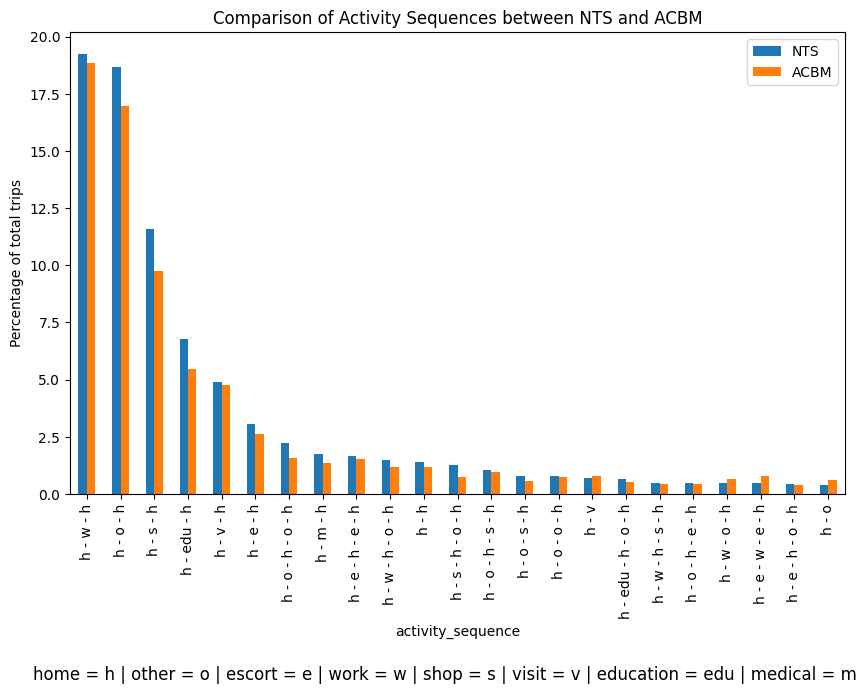

In [87]:
# join the two dataframes by 'activity_sequence'
sequence_nts_acbm = sequence_nts.merge(sequence_acbm, on='activity_sequence', how='inner').sort_values(by='count_nts', ascending=False)
sequence_nts_acbm

# Get % contribution of each unique activity sequence
sequence_nts_acbm['count_nts'] = sequence_nts_acbm['count_nts'] / sequence_nts_acbm['count_nts'].sum() * 100
sequence_nts_acbm['count_acbm'] = sequence_nts_acbm['count_acbm'] / sequence_nts_acbm['count_acbm'].sum() * 100

# Filter rows where both count columns are bigger than x %
x = 0.35

sequence_nts_acbm_filtered = sequence_nts_acbm[
    (sequence_nts_acbm['count_nts'] > x) & (sequence_nts_acbm['count_acbm'] > x)
]

# Plot the results as a bar chart
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

sequence_nts_acbm_filtered.plot(
    x='activity_sequence', 
    y=['count_nts', 'count_acbm'], 
    kind='bar', 
    ax=ax
)

plt.ylabel('Percentage of total trips')

plt.title('Comparison of Activity Sequences between NTS and ACBM')


# Generate custom legend
legend_labels = [f'{abbr} = {full}' for abbr, full in activity_mapping.items()]
custom_legend = ' | '.join(legend_labels)

# Add the custom legend to the plot
plt.legend(['NTS', 'ACBM'], loc='upper right')

# Add the custom legend below the chart
plt.figtext(0.5, -0.2, custom_legend, wrap=True, horizontalalignment='center', fontsize=12)

plt.show()


## Assigning: Trip distances

### Mean crowfly distance per trip purpose

### Crowfly distance cumulative chart (KM distance vs. % of trips)